In [34]:
import numpy as np
import pandas as pd
import gzip
from rdkit import DataStructs
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.inchi import MolToInchiKey

RDLogger.DisableLog('rdApp.error')

In [10]:
supp = Chem.SDMolSupplier('../data/drugbank.sdf')
drug_bank = [[mol, 'DrugBank'] for mol in supp if mol]

with gzip.open('actives_final.sdf.gz') as sdf:
    supp_actives = Chem.ForwardSDMolSupplier(sdf)
    actives = [[mol, 'actives'] for mol in supp_actives if mol]

with gzip.open('decoys_final.sdf.gz') as sdf:
    supp_decoys = Chem.ForwardSDMolSupplier(sdf)
    decoys = [[mol, 'decoys'] for mol in supp_decoys if mol]

df_db = pd.DataFrame(drug_bank, columns=['Mol', 'Source'])
df_ac = pd.DataFrame(actives, columns=['Mol', 'Source'])
df_de = pd.DataFrame(decoys, columns=['Mol', 'Source'])

df = pd.concat((df_db, df_ac, df_de), ignore_index=True)
df

RDKit WARNING: [12:47:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.
[12:47:43] WARNING: could not find number of expected rings. Switching to an approximate ring finding algorithm.


,Mol,Source
0,<rdkit.Chem.rdchem.Mol object at 0x7f57ba53cc60>,DrugBank
1,<rdkit.Chem.rdchem.Mol object at 0x7f57ba53cb70>,DrugBank
2,<rdkit.Chem.rdchem.Mol object at 0x7f57ba99acb0>,DrugBank
3,<rdkit.Chem.rdchem.Mol object at 0x7f57ba99aa30>,DrugBank
4,<rdkit.Chem.rdchem.Mol object at 0x7f57ba53cad0>,DrugBank
...,...,...
36236,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c300>,decoys
36237,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c3a0>,decoys
36238,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c440>,decoys
36239,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c4e0>,decoys


In [13]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [29]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic

def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

In [30]:
standardize(df.Mol[3465])

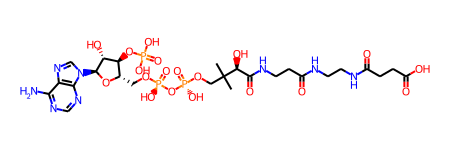

In [32]:
df.Mol[3465]

In [33]:
df['std_mol'] = df['Mol'].apply(lambda x: standardize(x))
df

,Mol,Source,std_mol
0,<rdkit.Chem.rdchem.Mol object at 0x7f57ba53cc60>,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x7f57ba9a0080>
1,<rdkit.Chem.rdchem.Mol object at 0x7f57ba53cb70>,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x7f57ba634cb0>
2,<rdkit.Chem.rdchem.Mol object at 0x7f57ba99acb0>,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x7f57b9ff7350>
3,<rdkit.Chem.rdchem.Mol object at 0x7f57ba99aa30>,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x7f57b9ff76c0>
4,<rdkit.Chem.rdchem.Mol object at 0x7f57ba53cad0>,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x7f57b9ff7a80>
...,...,...,...
36236,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c300>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f57b9cfe350>
36237,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c3a0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f57b9cfea80>
36238,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c440>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f57b9cfe4e0>
36239,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c4e0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f57b9cfe1c0>


In [39]:
def InchiKey_df(x):
    if x:
        return MolToInchiKey(x)
    else:
        return None

In [40]:
df['key_norm'] = df['Mol'].apply(lambda x: InchiKey_df(x))
df['key_std'] = df['std_mol'].apply(lambda x: InchiKey_df(x))
df

,Mol,Source,std_mol,key_norm,key_std
0,<rdkit.Chem.rdchem.Mol object at 0x7f57ba53cc60>,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x7f57ba9a0080>,OIRCOABEOLEUMC-GEJPAHFPSA-N,OIRCOABEOLEUMC-GEJPAHFPSA-N
1,<rdkit.Chem.rdchem.Mol object at 0x7f57ba53cb70>,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x7f57ba634cb0>,BLCLNMBMMGCOAS-URPVMXJPSA-N,BLCLNMBMMGCOAS-URPVMXJPSA-N
2,<rdkit.Chem.rdchem.Mol object at 0x7f57ba99acb0>,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x7f57b9ff7350>,NFLWUMRGJYTJIN-NXBWRCJVSA-N,NFLWUMRGJYTJIN-NXBWRCJVSA-N
3,<rdkit.Chem.rdchem.Mol object at 0x7f57ba99aa30>,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x7f57b9ff76c0>,SBNPWPIBESPSIF-MHWMIDJBSA-N,SBNPWPIBESPSIF-MHWMIDJBSA-N
4,<rdkit.Chem.rdchem.Mol object at 0x7f57ba53cad0>,DrugBank,<rdkit.Chem.rdchem.Mol object at 0x7f57b9ff7a80>,PMATZTZNYRCHOR-CGLBZJNRSA-N,PMATZTZNYRCHOR-CGLBZJNRSA-N
...,...,...,...,...,...
36236,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c300>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f57b9cfe350>,PEOJFVWQTHMENC-IBGZPJMESA-N,PEOJFVWQTHMENC-IBGZPJMESA-N
36237,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c3a0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f57b9cfea80>,FILWHYVYYNFMSI-IBGZPJMESA-N,FILWHYVYYNFMSI-IBGZPJMESA-N
36238,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c440>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f57b9cfe4e0>,OLBQYDDMDYEANS-GOSISDBHSA-N,OLBQYDDMDYEANS-GOSISDBHSA-N
36239,<rdkit.Chem.rdchem.Mol object at 0x7f57ba03c4e0>,decoys,<rdkit.Chem.rdchem.Mol object at 0x7f57b9cfe1c0>,HKDWPDFUQHDYOH-IBGZPJMESA-N,HKDWPDFUQHDYOH-IBGZPJMESA-N


In [41]:
def compare(x,y):
    if x == y:
        return 'Match'
    if not x or not y:
        return 'Out'
    if x != y:
        return 'Modified'

In [42]:
df['STD_result'] = df.apply(lambda x: compare(x.key_norm, x.key_std), axis=1)
df['STD_result'].value_counts()

Match       25693
Modified     9477
Out          1071
Name: STD_result, dtype: int64

In [46]:
df[df.STD_result == 'Out'].Source.value_counts()

DrugBank    967
decoys      104
Name: Source, dtype: int64

-----------------------------

In [56]:
df2 = pd.DataFrame(np.load('df.npy', allow_pickle=True))
df2.columns = ['Mol', 'Source', 'FP']

D = pd.DataFrame(np.load('dist_matrix.npy'))
D

,0,1,2,3,4,5,6,7,8,9,...,7903,7904,7905,7906,7907,7908,7909,7910,7911,7912
0,1.000000,0.371069,0.407143,0.492754,0.115385,0.314685,0.201258,0.078740,0.115578,0.182482,...,0.098592,0.106383,0.105634,0.099291,0.127820,0.102941,0.084615,0.175182,0.182482,0.076389
1,0.371069,1.000000,0.306250,0.415584,0.120482,0.265823,0.260870,0.095588,0.125000,0.160000,...,0.127517,0.127517,0.126667,0.128378,0.148936,0.132867,0.125000,0.153333,0.167785,0.105960
2,0.407143,0.306250,1.000000,0.358621,0.130137,0.721154,0.281690,0.075630,0.157609,0.176923,...,0.122137,0.113636,0.121212,0.114504,0.137097,0.128000,0.109244,0.151515,0.159091,0.081481
3,0.492754,0.415584,0.358621,1.000000,0.101266,0.278912,0.201258,0.087302,0.115578,0.140845,...,0.106383,0.090909,0.105634,0.091549,0.119403,0.119403,0.101562,0.219697,0.227273,0.091549
4,0.115385,0.120482,0.130137,0.101266,1.000000,0.138686,0.152174,0.060606,0.124260,0.111111,...,0.078261,0.087719,0.068376,0.098214,0.072727,0.082569,0.079208,0.112069,0.130435,0.078947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,0.102941,0.132867,0.128000,0.119403,0.082569,0.118644,0.106557,0.125000,0.099338,0.152174,...,0.428571,0.351351,0.422535,0.356164,0.678571,1.000000,0.133333,0.141304,0.152174,0.207317
7909,0.084615,0.125000,0.109244,0.101562,0.079208,0.118182,0.095652,0.180328,0.075342,0.127907,...,0.109756,0.109756,0.108434,0.111111,0.133333,0.133333,1.000000,0.142857,0.141176,0.058824
7910,0.175182,0.153333,0.151515,0.219697,0.112069,0.144000,0.140625,0.082353,0.099379,0.147059,...,0.132653,0.132653,0.131313,0.134021,0.166667,0.141304,0.142857,1.000000,0.746269,0.134021
7911,0.182482,0.167785,0.159091,0.227273,0.130435,0.142857,0.148438,0.081395,0.105590,0.156863,...,0.131313,0.131313,0.118812,0.144330,0.152174,0.152174,0.141176,0.746269,1.000000,0.121212


In [54]:
D['ave'] = D.mean(numeric_only=True, axis=1)
top = D.sort_values(by='ave', ascending=True)[0:10]

In [55]:
top.index.values

array([6852, 6982, 7018, 6876, 4663, 1199, 1202, 7010, 1379, 7042])

In [57]:
df.Source.value_counts()

decoys      28328
DrugBank     7115
actives       798
Name: Source, dtype: int64